In [1]:
import os

import cv2
import numpy as np
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler
from diffusers.utils import load_image
from PIL import Image

# Canny ControlNet

In [2]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16).to("cuda")

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    os.path.abspath(os.path.join(os.pardir, "models", "dreambooth")), controlnet=controlnet, torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ildar.azamatov/projects/itmo/itmo-generative-models/.venv/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [3]:
image = load_image(
    "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/1665_Girl_with_a_Pearl_Earring.jpg/270px-1665_Girl_with_a_Pearl_Earring.jpg"
)

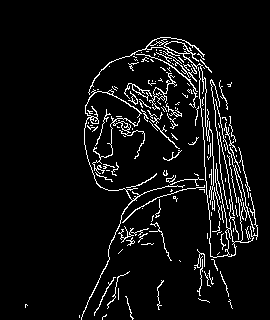

In [4]:
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [5]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [6]:
token = "sks"
promt_list = [
    {
        "name": "gir_with_pearl_earring",
        "prompt": f"close up portrait of smiling {token} woman, red carpet, 4K, raw, hrd, hd, high quality, realism, sharp focus",
        "n_prompt": "monochrome, lowres, bad anatomy, worst quality, low quality, naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
]


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [7]:
seed = 147525234
num_samples = 1
guidance_scale = 6
num_inference_steps = 35
controlnet_conditioning_scale = 0.55

  0%|          | 0/35 [00:00<?, ?it/s]

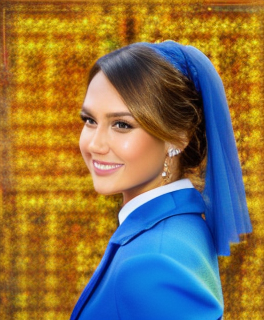

In [8]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


prompt = promt_list[0]["prompt"]
negative_prompt = promt_list[0]["n_prompt"]
generator = [torch.Generator(device="cpu").manual_seed(i + 3) for i in range(num_samples)]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=negative_prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=generator,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
)

image_grid(output.images, 1, 1)